In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

FS = 12 # fontsize

In [2]:
def read_fast5(fname, single_or_multi_read, get_read_ids=False):
    'read only one fast5 file'
    from ont_fast5_api.fast5_interface import get_fast5_file
    def raw_to_current(rawdata, offset, range_, digitisation):
        return list((np.array(rawdata) + offset) * range_ / digitisation)
    
    if single_or_multi_read not in ['s', 'm']:
        raise ValueError('single_or_multi variable must be "s" or "m".')
    data = []
    read_ids = []
    with get_fast5_file(fname, mode="r") as f:
        for read in f.get_reads():
            ch=read.get_channel_info()
            data.append(raw_to_current(read.get_raw_data(), ch['offset'], ch['range'], ch['digitisation']))
            read_ids.append(read.read_id)
    if single_or_multi_read == 's':
        if get_read_ids:
            return np.array(data[0]), read_ids
        return np.array(data[0]) # single read --> dim=1
    elif single_or_multi_read == 'm':
        if get_read_ids:
            return np.array(data, dtype='object'), read_ids
        return np.array(data, dtype='object')

def find_read_id_index(string_list, search_string):
    string_array = np.array(string_list)
    index = np.where(np.char.find(string_array, search_string) != -1)[0]
    if len(index) == 1:
        return index[0]
    print(f'Error: no or more indices found; len(index)={len(index)}')
    return None

def split_raw_signal(raw_signal, move_table, stride):
    start_of_bases = (np.where(move_table == 1)[0]) * stride
    signals = [raw_signal[i:j] for i, j in zip(start_of_bases, start_of_bases[1:])]
    mean_signals = [np.mean(raw_signal[i:j]) for i, j in zip(start_of_bases, start_of_bases[1:])]
    return start_of_bases, signals, mean_signals

def replace_T_to_U(data):
    if  type(data) not in [list, np.ndarray]:
        raise TypeError(f'sam_file_names must be a list')
    for record in tqdm(data, total=len(data), desc='Replacing'):
        record['sequence'] = np.array(['U' if base == 'T' else base for base in record['sequence']])
    return np.array(data)

In [3]:
def get_data(sam):
    pattern = re.compile(r'(\d+)([MIDNSHP=X])')
    cigar_str = np.array(pattern.findall(sam[5])).T
    mv_table = np.fromstring(sam[21].split("[")[1].split("]")[0], sep=',', dtype=int)
    return  {
        'read_id':sam[0], 
        'sam_flag':int(sam[1]),
        'mapped_position':int(sam[3]),
        'map_quality':int(sam[4]),
        'cigar_str':(cigar_str[0].astype(int), cigar_str[1]),
        'sequence':np.array(list(sam[9])),
        'move_table':mv_table[1:],
        'stride':mv_table[0],
        'trim_offset':int(sam[29][3:]),
        'fast5_file_name':sam[27][3:]
       } 

def read_sam(sam_file_names, min_length=0, max_length=1e5, min_MAPQ=0, wrong_flags={4, 256, 272, 2048, 2064}):
    ''' read sam file '''
    ### For more files
    if  type(sam_file_names) == list:
        all_sam_data = []
        for sam_file_name in tqdm(sam_file_names, total=len(sam_file_names), desc='Loading data'):
            with open(sam_file_name, 'r') as file:
                sam_file = file.read().split('\n')[:-1]
                sam_file = [line for line in sam_file if not line.startswith('@')]
            one_sam_data = []
            for line in sam_file:
                sam = line.split('\t')
                # There are cases, when tags (or the whole sequence) are missing (or in a few cases one line added.)
                if len(sam)==31:
                    data = get_data(sam)
                    if (len(data['sequence']) <= max_length and
                        len(data['sequence']) >= min_length and
                        data['map_quality'] >= min_MAPQ and
                        data['sam_flag'] not in wrong_flags                     
                       ): one_sam_data.append(data)
            all_sam_data.append(np.array(one_sam_data, dtype='object'))
        return np.hstack(all_sam_data, dtype='object')
        
    ### For only one file
    elif  type(sam_file_names) == str:
        with open(sam_file_names, 'r') as file:
            sam_file = file.read().split('\n')[:-1]
            sam_file = [line for line in sam_file if not line.startswith('@')]
        sam_data = []
        for line in tqdm(sam_file,  total=len(sam_file), desc="Loading file"):
            sam = line.split('\t')
            if len(sam)==31:
                data = get_data(sam)
                if (len(data['sequence']) <= max_length and
                    len(data['sequence']) >= min_length and
                    data['map_quality'] >= min_MAPQ and
                    data['sam_flag'] not in wrong_flags                     
                   ): sam_data.append(data)
        return np.array(sam_data, dtype='object')

    else:
        raise TypeError(f"'sam_file_names' must be a string or list of strings, not {type(sam_file_names)}")

In [28]:
def get_feature_from_sam_data(data, feature):
    return np.array([entry[feature] for entry in data ], dtype='object')

def search_in_data(data, key, element):
    for entry in data:
        if entry[key] == element:
            return entry
    return None

---
# Reference file

In [5]:
with open("/v/volumes/nanopore/ref/p300_ID3.fasta", 'r') as file:
    p300_ID3_ref = file.read().split('\n')[1]
p300_ID3_ref = np.array(list(p300_ID3_ref))
print(f'Length of ref sequence: {len(p300_ID3_ref)}')
p300_ID3_ref

Length of ref sequence: 1164


array(['A', 'A', 'C', ..., 'C', 'A', 'G'], dtype='<U1')

The position of that thymine which has the furthest distances from another thymine in both two directions.

In [6]:
def find_the_greatest_neighbors(dst):
    'Squared geometric mean'
    geom_mean_sq = []
    for i in range(len(dst)-1):
        geom_mean_sq.append(dst[i]*dst[i+1] )
    return np.argmax(geom_mean_sq)+1

positions = np.where(p300_ID3_ref == 'T')[0]
distances = np.diff(positions)
position = find_the_greatest_neighbors(distances)
print(f"The position: {positions[position]}")
print(f"Distances: {distances[position-2: position+2]}")
p300_ID3_ref[positions[position]-15:positions[position]+21]

The position: 692
Distances: [ 6 15 20  1]


array(['T', 'C', 'C', 'A', 'A', 'G', 'G', 'C', 'A', 'G', 'A', 'C', 'A',
       'C', 'C', 'T', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'A',
       'C', 'A', 'A', 'C', 'A', 'C', 'A', 'A', 'C', 'T'], dtype='<U1')

In [7]:
p300_ID3_ref[399:420]

array(['G', 'C', 'T', 'C', 'C', 'A', 'G', 'T', 'G', 'T', 'C', 'T', 'C',
       'A', 'A', 'G', 'C', 'A', 'C', 'A', 'A'], dtype='<U1')

---
# Thymine

### Questions:
- read reverse strand: should I mirror the sequence? $\xrightarrow{}$ No, it means complementer chain.

In [8]:
#path_to_Thymine_fast5 = '/v/projects/nanopore/agnes/signal_visualization/data/timin0421/workspace/'
#T_fast5_files = glob(path_to_Thymine_fast5+'*.fast5')
#idx1 = 0
#T_fast5_file_path = path_to_Thymine_fast5 + T_sam_data[idx1]['fast5_file_name']
#fast5_signals, read_ids = read_fast5(T_fast5_file_path, 'm', get_read_ids=True)

In [24]:
T_sam_data = read_sam(sorted(glob("/v/projects/nanopore/balazs/data/thymine_0421/*0.sam")),
                      min_length=len(p300_ID3_ref)*0.6,
                      max_length=len(p300_ID3_ref)*1.1, # more than 100 inserted bases
                      min_MAPQ=40,
                     )

Loading data: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


In [10]:
T_sam_data[0] # random read from the data

{'read_id': '00a040a3-847b-4397-bf7e-cbb8fc77fa97',
 'sam_flag': 0,
 'mapped_position': 4,
 'map_quality': 60,
 'cigar_str': (array([ 28,  48,   1,  88,   1,  60,   2,   5,   1,   5,   3,   8,   1,
           5,   1,  67,   2,   7,   2,  72,   1,  99,   1,  96,   1,  56,
           3,   4,   1,  49,   1,  63,   2,  13,   2,  29,   1,  49,   1,
          13,   1,  36,   1,   5,   1,   3,   1, 181,   1,  47,   3,  35,
           9]),
  array(['S', 'M', 'D', 'M', 'I', 'M', 'D', 'M', 'I', 'M', 'D', 'M', 'I',
         'M', 'I', 'M', 'I', 'M', 'I', 'M', 'I', 'M', 'D', 'M', 'D', 'M',
         'I', 'M', 'I', 'M', 'I', 'M', 'D', 'M', 'I', 'M', 'I', 'M', 'I',
         'M', 'I', 'M', 'I', 'M', 'D', 'M', 'D', 'M', 'D', 'M', 'I', 'M',
         'S'], dtype='<U3')),
 'sequence': array(['A', 'T', 'A', ..., 'G', 'T', 'G'], dtype='<U1'),
 'move_table': array([1, 1, 0, ..., 0, 0, 0]),
 'stride': 5,
 'trim_offset': 125,
 'fast5_file_name': 'aoa546_pass_235c7b69_db4f2d16_18.fast5'}

In [11]:
T_sam_data[0]['sequence'].shape[0]

1203

In [14]:
#np.array([T_sam_data[0]['cigar_str'][0], T_sam_data[0]['cigar_str'][1]]).T

In [ ]:
xlim_min=0
xlim_max=50

plt.hist(possible_positions, bins=max(possible_positions), color='blue', alpha=0.7)
plt.yscale('log')
plt.xlim(xlim_min, xlim_max)
plt.grid('dotted')
plt.xticks(np.arange(xlim_min, xlim_max, 2)+0.5, np.arange(xlim_min, xlim_max, 2))
plt.show()

In [ ]:
all_bases_T = get_feature_from_sam_data(T_sam_data, 'sequence')

all_bases_length_T = []
for item in all_bases_T:
    all_bases_length_T.append(len(item))

plt.plot(sorted(all_bases_length_T))
plt.grid()

---
# Uracil

In [34]:
U_sam_data = read_sam(sorted(glob("/v/projects/nanopore/balazs/data/uracil_0504/*0.sam")),
                      min_length=len(p300_ID3_ref)*0.5,
                      max_length=len(p300_ID3_ref)*1.1,
                      min_MAPQ=40,
                     )

Loading data: 100%|██████████| 67/67 [01:42<00:00,  1.53s/it]


In [37]:
sum(get_feature_from_sam_data(U_sam_data, 'read_id') == '064d1dc6-8970-4302-abeb-4aaa1147e82d')

1

In [ ]:
U_sam_data.shape

In [ ]:
mapq = get_feature_from_sam_data(U_sam_data, 'map_quality')

In [ ]:
plt.plot(mapq)

In [57]:
path_to_Uracil_fast5 = '/v/projects/nanopore/agnes/signal_visualization/uracil0504/guppy/workspace/'
U_fast5_files = glob(path_to_Uracil_fast5+'*.fast5')

#index_of_fast5 = 0
#fast5_file_path = path_to_Uracil_fast5 + U_sam_data[index_of_fast5]['fast5_file_name']
#fast5_signals, read_ids = read_fast5(fast5_file_path, 'm', get_read_ids=True)

In [ ]:
# Replace thymine to uracil
#U_sam_data = replace_T_to_U(U_sam_data) # ~3min

In [ ]:
all_bases_U = get_feature_from_sam_data(U_sam_data, 'sequence')

all_bases_length_U = []
for item in all_bases_U:
    all_bases_length_U.append(len(item))

plt.plot(sorted(all_bases_length_U))
plt.grid()

In [58]:
pileup_first_read = search_in_data(U_sam_data, 'read_id', '064d1dc6-8970-4302-abeb-4aaa1147e82d')

In [64]:
fast5_file_path = path_to_Uracil_fast5 + pileup_first_read['fast5_file_name']
fast5_signals, read_ids = read_fast5(fast5_file_path, 'm', get_read_ids=True)

In [75]:
read_index = np.where(np.array(read_ids) == '064d1dc6-8970-4302-abeb-4aaa1147e82d')[0][0]

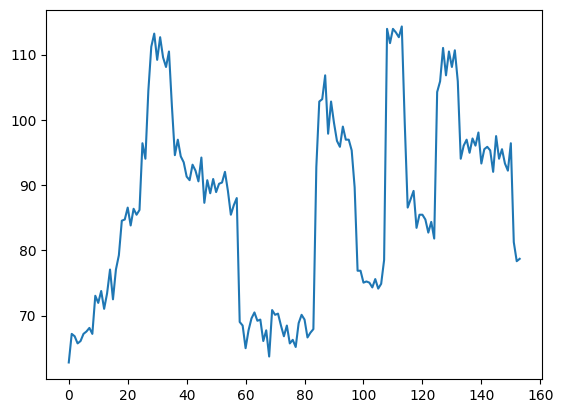

In [84]:
plt.plot(fast5_signals[read_index][4746:4900])

In [97]:
pileup_first_read['cigar_str']

(array([ 33,  37,   2,   6,   1, 177,   1, 150,   1,  26,   1,  72,   1,
         64,   1,   9,   1,   9,   1, 181,   1, 175,   2,  36,   1,  27,
          1,  72,   2,  20,   6,  24,   1,   9,   2,  36,  16]),
 array(['S', 'M', 'D', 'M', 'D', 'M', 'D', 'M', 'D', 'M', 'I', 'M', 'D',
        'M', 'I', 'M', 'I', 'M', 'D', 'M', 'D', 'M', 'D', 'M', 'D', 'M',
        'D', 'M', 'I', 'M', 'D', 'M', 'D', 'M', 'I', 'M', 'S'], dtype='<U3'))

In [98]:
pileup_first_read['sequence'][33+399:33+410]

array(['C', 'A', 'G', 'T', 'G', 'T', 'C', 'T', 'C', 'A', 'A'], dtype='<U1')